<a href="https://colab.research.google.com/github/QianyueWang0212/mgmt467-analytics-portfolio/blob/main/Labs/Lab3_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the Google Cloud BigQuery client library
!pip install google-cloud-bigquery==3.17.0 pandas==2.1.4

# Authenticate your Colab environment
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.2/230.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.38.0
    Uninstalling google-cloud-bigquery-3.38.0:
      Successfully uninstalled google-cloud-bigquery-3.38.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

KeyboardInterrupt: 

In [1]:
from google.cloud import bigquery
import pandas as pd

# Replace with your Google Cloud Project ID
project_id = 'mgmt-46700'
dataset_id = 'lab_foundation_qw'
table_id = 'superstore'

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

# Get the table object
table_ref = client.dataset(dataset_id).table(table_id)
table = client.get_table(table_ref)

# Extract schema information
schema_list = []
for field in table.schema:
    schema_list.append({
        'name': field.name,
        'field_type': field.field_type,
        'mode': field.mode,
        'description': field.description
    })

# Convert to Pandas DataFrame
schema_df = pd.DataFrame(schema_list)

# Display the schema DataFrame (optional, for verification)
print("Schema DataFrame created:")
# To see the output, run the code.

Schema DataFrame created:


In [3]:
# --- 1. Clean the Column Names ---
# Create a 'clean_name' column with standard naming conventions:
# lowercase, with spaces and hyphens replaced by underscores.
schema_df['clean_name'] = schema_df['name'].str.lower().str.replace(' ', '_').str.replace('-', '_')


# --- 2. Generate the Aliases for the SELECT Clause ---
column_expressions = []
for index, row in schema_df.iterrows():
    original_name = row['name']
    clean_name = row['clean_name']

    # If the original name contains a space or special character, it needs to be
    # enclosed in backticks (`) in the SQL statement.
    if ' ' in original_name or '-' in original_name:
        expression = f'`{original_name}` AS {clean_name}'
    else:
        # If the name is already clean, we still alias it for consistency.
        expression = f'{original_name} AS {clean_name}'
    column_expressions.append(expression)

# Join all the individual column expressions into a single, formatted string.
select_clause = ",\n  ".join(column_expressions)


# --- 3. Construct the Final CREATE VIEW Statement ---
new_view_id = 'superstore_clean' # You can change this if you like

create_view_sql = f"""
CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.{new_view_id}` AS
SELECT
  {select_clause}
FROM
  `{project_id}.{dataset_id}.{table_id}`;
"""

# --- 4. Print the Final SQL ---
print("--- Copy the SQL below and run it in your BigQuery Console ---")
print(create_view_sql)

--- Copy the SQL below and run it in your BigQuery Console ---

CREATE OR REPLACE VIEW `mgmt-46700.lab_foundation_qw.superstore_clean` AS
SELECT
  `Row ID` AS row_id,
  `Order ID` AS order_id,
  `Order Date` AS order_date,
  `Ship Date` AS ship_date,
  `Ship Mode` AS ship_mode,
  `Customer ID` AS customer_id,
  `Customer Name` AS customer_name,
  Segment AS segment,
  Country AS country,
  City AS city,
  State AS state,
  `Postal Code` AS postal_code,
  Region AS region,
  `Product ID` AS product_id,
  Category AS category,
  `Sub-Category` AS sub_category,
  `Product Name` AS product_name,
  Sales AS sales,
  Quantity AS quantity,
  Discount AS discount,
  Profit AS profit
FROM
  `mgmt-46700.lab_foundation_qw.superstore`;



Step 1 – Interactive Exploratory Analysis (Plotly Bubble Chart):

Analysis Question: “What is the relationship between discounts, profit, and sales across product sub-categories?”

Action: Use the precise Gemini prompt below. This is an example of a high-quality prompt that follows the

Prompt Quality Checklist.

Precise Prompt:

Python
prompt =
```
# TASK: Generate Python code using plotly.express.
# GOAL: Create an interactive bubble chart to visualize the relationship between profitability, sales, and discounts.
# CONTEXT: I have a pandas DataFrame with columns 'Sub_Category', 'Category', 'Sales', 'Profit', 'Discount'.
# SPECIFICATIONS:
# - The x-axis must be 'Discount'.
# - The y-axis must be 'Profit'.
# - The size of the bubbles must represent 'Sales'.
# - The color of the bubbles must represent the parent 'Category'.
# - When a user hovers over a bubble, it must display the 'Sub_Category', 'Sales', 'Profit', and 'Discount' values.
# - Include a clear title and axis labels.
```
Deliverable: Text cell noting one insight only visible through interactivity (e.g., “Tables had high sales but negative profit when discounts exceeded 30%.”).

In [4]:
# Fetch the data from BigQuery into a pandas DataFrame
query = f"""
SELECT
  `Sub-Category` AS Sub_Category,
  Category AS Category,
  Sales AS Sales,
  Profit AS Profit,
  Discount AS Discount
FROM
  `{project_id}.{dataset_id}.{table_id}`
"""
df = client.query(query).to_dataframe()

# Generate the bubble chart using plotly.express
import plotly.express as px

fig = px.scatter(df,
                 x="Discount",
                 y="Profit",
                 size="Sales",
                 color="Category",
                 hover_name="Sub_Category",
                 hover_data={"Sub_Category": True,
                             "Sales": True,
                             "Profit": True,
                             "Discount": True},
                 title="Relationship between Discount, Profit, and Sales across Product Sub-Categories")

fig.update_layout(xaxis_title="Discount",
                  yaxis_title="Profit")

fig.show()

One insight I noticed through interactivity is that Technology products with discounts around 50% or higher often show large sales volumes but turn unprofitable, with profits dropping below –$5K. Hovering over these points confirmed that deep discounting can boost sales size but severely hurts margins.

Step 2 – Explanatory Dashboard (Looker Studio):

Business Goal: Create an executive summary dashboard.

Action: Include:

Scorecard → total overall Profit.

Pie Chart → Sales % by Region.

Bar Chart → Top 5 States by Sales.

Deliverable: Public Looker Studio share link + screenshot embedded in notebook.



https://lookerstudio.google.com/s/mHqLYKW-BKw

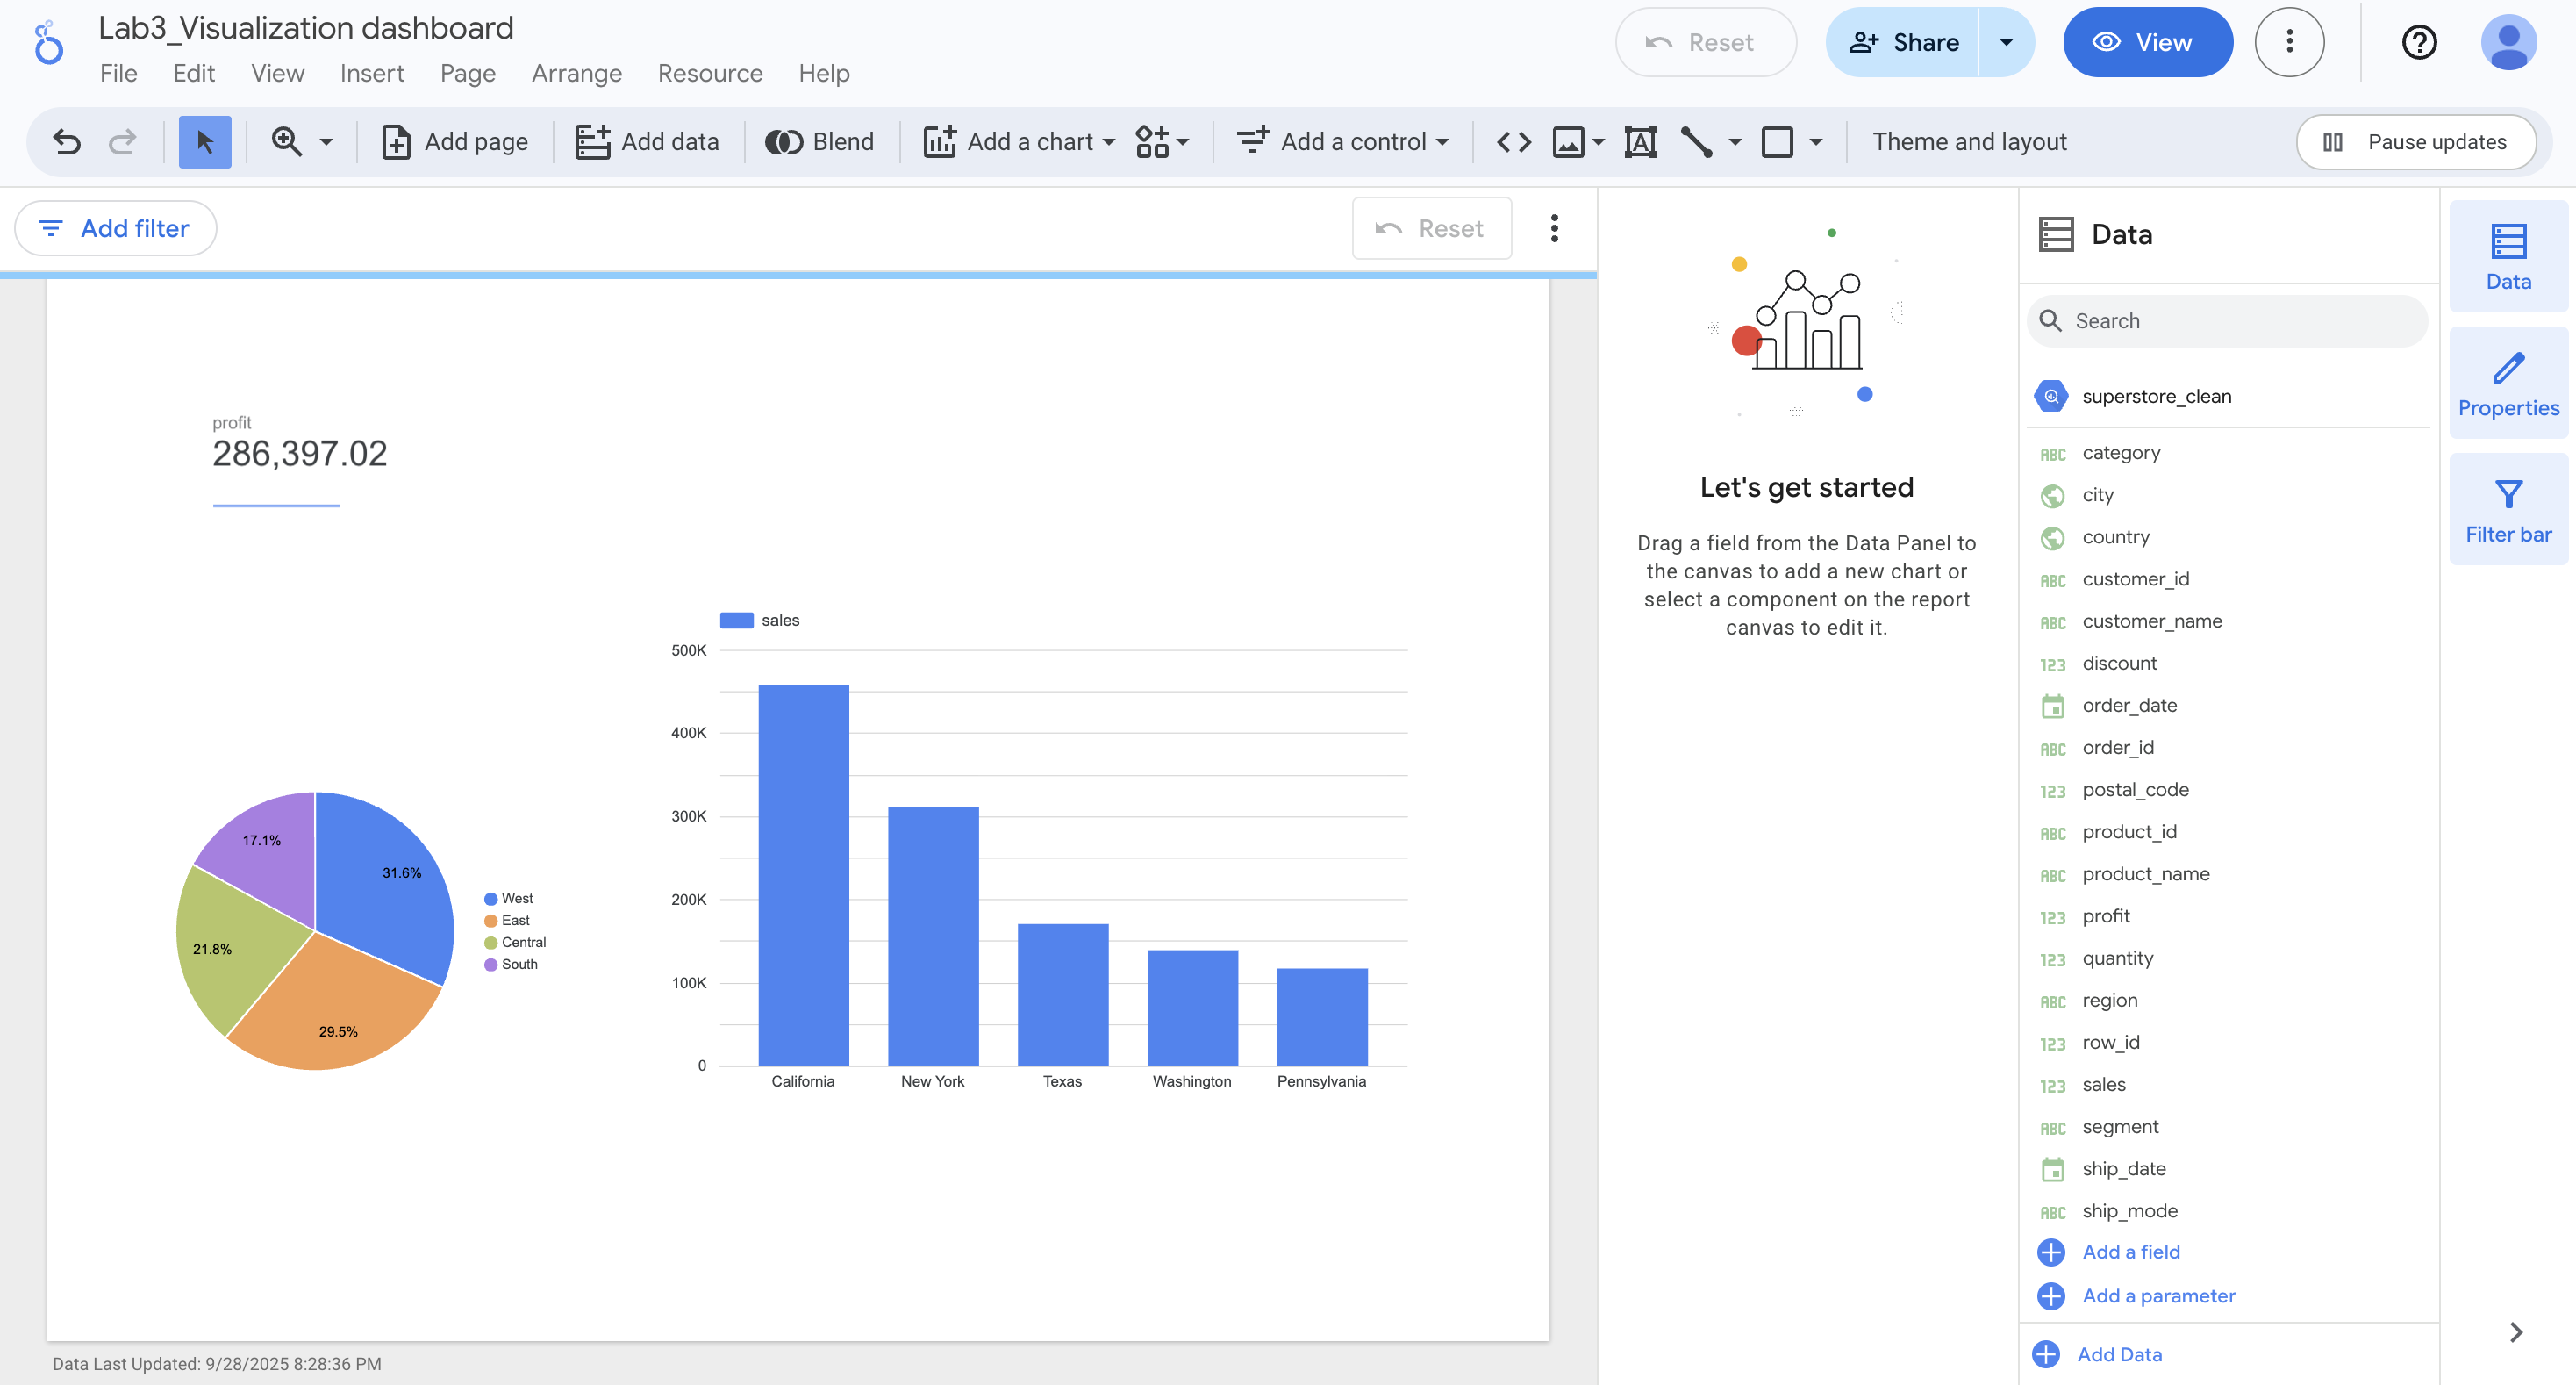



E – Extend (Recommendation with Strategist Pattern):

After embedding the screenshot, write a recommendation for executives by adapting the

Strategist Pattern.

Precise Prompt:

Python
prompt =
```
# TASK: Act as a business strategist.
# CONTEXT: An executive is looking at a dashboard that shows [describe a key insight from your Looker dashboard, e.g., 'the Central region has the lowest sales'].
# GOAL: Based ONLY on this insight, recommend one immediate, specific, and actionable step a Sales Director should take to address this.

```
Deliverable: Short text-cell recommendation (1–2 sentences).

The dashboard shows that the South region has the lowest share of sales at only 17.1% compared to other regions. As a Sales Director, the immediate step should be to launch a targeted promotional campaign in the South to boost customer demand. This could include region-specific discounts, partnerships with local retailers, or reallocating a portion of the sales team’s resources to expand outreach and capture more market share in that underperforming region.


Challenge: Construct Your Own Prompts

For each challenge below, author and document your own precise Gemini prompt.

Challenge Question 1: "A manager has a hypothesis: 'For the Office Supplies category, offering higher average discounts does not lead to higher total sales.' Author a single, multi-step prompt for Gemini that first generates the BigQuery SQL to get the necessary data (average discount and total sales per sub-category) and then generates the Plotly code for an interactive scatter plot to visually prove or disprove this hypothesis."

Challenge Question 2: "From your bubble chart, you discovered that 'Tables' are a high-sales but negative-profit sub-category. Author a prompt using the Explainer Pattern from our library to generate a simple, non-technical explanation for a sales manager, including an analogy they would understand."

Challenge 1
```
# TASK: Generate both a BigQuery SQL query and Python Plotly code.
# GOAL: Test the hypothesis that in the 'Office Supplies' category, higher average discounts do not lead to higher total sales.
# STEP 1 (SQL): Write a BigQuery query that selects Sub_Category, the average discount, and total sales, filtering only for Category = 'Office Supplies'. Group results by Sub_Category.
# STEP 2 (Plotly): Using the SQL output loaded into a pandas DataFrame, create an interactive scatter plot where:
#   - x-axis = average discount
#   - y-axis = total sales
#   - each point = one Sub_Category
#   - hover labels show Sub_Category, average discount, and total sales
#   - include a clear title and axis labels.
# CONTEXT: The chart must help a manager visually evaluate whether larger discounts correlate with higher or lower sales within Office Supplies.


Challenge 2
```
# TASK: Use the Explainer Pattern to generate a plain-language explanation.
# GOAL: Explain to a sales manager why the 'Tables' sub-category shows high sales but negative profit.
# CONTEXT: Avoid technical jargon and focus on business storytelling.
# SPECIFICATIONS:
# - Use a simple analogy (e.g., “selling lemonade below cost”) to make the concept relatable.
# - Clearly state that even though revenue looks strong, discounts and costs outweigh it, turning profit negative.
# - Keep the explanation concise (3–4 sentences).
# - Audience: a sales manager with no technical background.
